# Run a genetic optimization
In this notebook, we demonstrate how to set the parameters for the genetic algorithm with the controller shown in the previous notebook. We will also try to explain how to create custom parameters for other controllers (TODO).

In [87]:
# coding: utf8
import os, sys
from sys import argv
sys.path.insert(0, os.getcwd()) # adds current directory to python path

from isae.optim.genAlg import *
from isae.optim.multiprocessGenAlg import *
from datetime import datetime

# Colors for console outputs
BLUE = "\033[34m"
GREEN = "\033[32m"
DEFAULT = "\033[39m"
YELLOW = "\033[33m"
CYAN = "\033[36m"
RED = "\033[91m"

## Genetic algorithm initialization
Here, we instantiate the `geneticAlgorithm` class (using 1 CPU) or the `multiprocessGeneticAlgorithm` class (using all CPUs) that will handle the optimization process : population initialization, evaluation, reproduction, and mutation for a given number of solutions and of generations.

In [88]:
#GA = geneticAlgorithm()
GA = multiprocessGeneticAlgorithm()

## Setting the hyperparameters
We now set the hyperparameters, i.e. the parameters of the optimization process itself.

In [89]:
GA.pop_size = 100
# Number of solutions at each generation
GA.n_gen = 20
# Number of generations i.e. optimization steps on the population
GA.grade_index = 3 
# in gradedSimulation objects, will use gradedSim.grades[grade_index] as optimization goal (maximization)

## (TEMPORARY) Setting the simulation initialization function
The current implementation requires to write a custom simulation initialization function `paramToSim` for each set of parameters that the genetic algorithm will optimize. It takes as inputs a genAlgParam[] list of parameters, and returns a `gradedSimulation` instance defined as needed to fit the input prameters. We demonstrate 1 example here that optimizes : 
- max. dist. between front hips and feet : `bh0 = paramsInstance[0].value`
- max. dist. between rear hips and feet : `bh1 = paramsInstance[1].value`
- foot target trajectory, as `footTrajectory` instance : `trajPoints0 = paramsInstance[2].value`

These parameters can be optimized by the genetic algorithm because they implement a `genAlgParam` wrapper class, that allows them to be manipulated for random initialization, reproduction and mutation steps. The `paramToSim` function is used as an external parameter to define the evaluation step.

If you checkout the branch to develop it yourself, make sure to also modify the `genAlg` class to reflect new `genAlgParam` you implement : in the `genAlg.initPopulation()` method, you should add a string allowing to define the initialization of this new parameter. 

In [91]:
def paramToSim_Bh_Traj(paramsInstance):
    # Mapping input parameters to controller parameters
    bh0 = paramsInstance[0].value
    bh1 = paramsInstance[1].value
    trajPoints0 = paramsInstance[2].value

    # Loop parameters 
    pyb_gui = False
    duration = 8
    period = 1.2

    offsets = [0.5,0.,0.5,0.]
    bodyHeights = 2*[bh0] + 2*[bh1]

    footTraj1 = footTrajectory(           trajPoints0              , phaseOffset = offsets[0])
    footTraj2 = footTrajectory(         footTraj1.points           , phaseOffset = offsets[1])
    footTraj3 = footTrajectory(         footTraj1.points           , phaseOffset = offsets[2])
    footTraj4 = footTrajectory(         footTraj1.points           , phaseOffset = offsets[3])
    trajs = [footTraj1, footTraj2, footTraj3, footTraj4]

    leg = Leg(1,1)
    sols = [False, False, True, True]
    #sols = [True, True, False, False]
    #sols = [False, False, False, False]
    #sols = [True, True, True, True]
    
    Kp = 10
    Kd = 0.2

    robotController = footTrajController(bodyHeights, leg, sols, trajs, period, Kp, Kd, 3 * np.ones((8, 1)))
    
    # Initialize gradedSimulation, stop right before gradedSim.initializeSim()
    simInstance = gradedSimulation()
    simInstance.setLoopParams(pyb_gui, duration)
    simInstance.setController(robotController)
    simInstance.setTrajectoryParams(leg, period, trajs, bodyHeights)

    return simInstance

# Assign paramToSim function to GA
GA.setParamToSim(paramToSim_Bh_Traj)

## Defining the parameters to optimize
This is where we define the `genAlgParam` classes that we want to instantiate for each potential solution, mostly setting parameters for their random initiaization ranges in `paramArgs`.

In [98]:
# params : bh1, bh2, footTraj
paramTypes = ["scalar", "scalar", "ptFtTraj"]
paramArgs = [[1.,1.6],[1.,1.6],[[-1.2,1.2],[0,1.],[3,5]] ]
paramNames = ["BH0", "BH1", "FootTraj"]

Finally, we assign these parameters to the genetic agorithm :

In [99]:
GA.setParamTypes(paramTypes)
GA.setParamArgs(paramArgs)
GA.setParamNames(paramNames)

The following lines simply run the optimization process with console output and generate a log file, populated along the optimization process by the `geneticAlgorithm` class.

In [ ]:
GA.runOptim()
genLog = GA.genLog




GEN 0
Pop size : 100
##########################################
Simulation finished in 8.875124999999999 s
##########################################
Indiv. AmAXYaC : 
[1.449492864671919 1.017755111725975
 array([[-0.78569755,  0.08586845],
       [ 0.26837623,  0.39216011],
       [ 0.54275954,  0.90542717],
       [ 1.04171266,  0.21537227],
       [ 1.13085865,  0.74057895],
       [-0.78569755,  0.08586845]])]
Fitness : 1.5128960029113598


##########################################
Simulation finished in 9.138535 s
##########################################
Indiv. oyBOaHY : 
[1.049319925159963 1.3015868909530277
 array([[-1.11153606,  0.63228825],
       [-0.34771986,  0.92843957],
       [ 0.68832551,  0.99943518],
       [ 0.47348576,  0.58323007],
       [-0.50235649,  0.45771106],
       [-1.11153606,  0.63228825]])]
Fitness : 0.4992680992221732


##########################################
Simulation finished in 9.31701 s
##########################################
Indiv. Ga



##########################################
Simulation finished in 8.990144 s
##########################################
Indiv. HfEkbsG : 
[1.0544365381823155 1.2743883129669946
 array([[-0.63591174,  0.83076355],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-0.63591174,  0.83076355]])]
Fitness : 1.4884486747402117


##########################################
Simulation finished in 9.797094 s
##########################################
Indiv. ruRlJKP : 
[1.1266717373169821 1.3291526600138508
 array([[-1.09465756,  0.14387469],
       [ 0.27587698,  0.63573843],
       [ 0.30687664,  0.74005558],
       [ 0.33819401,  0.99154053],
       [-1.09465756,  0.14387469]])]
Fitness : -0.1339350946313229


##########################################
Simulation finished in 9.125554 s
##########################################
Indiv. ZaXEGOO : 
[1.4911916266432836 1.1564176847960335
 array([[-1.02633152,  0.15369794],
       [ 0.1

       [-0.21683259,  0.41723777]])]
Fitness : 1.050460534253298


##########################################
Simulation finished in 9.716956 s
##########################################
Indiv. TldtVfP : 
[1.3648513916983536 1.522730315972892
 array([[-0.32667015,  0.29183563],
       [ 0.63348864,  0.95609134],
       [ 0.90317285,  0.59962997],
       [-0.32667015,  0.29183563]])]
Fitness : 1.091793374212276


##########################################
Simulation finished in 9.569899 s
##########################################
Indiv. xLmvaZU : 
[1.3710757048026467 1.5242373932550826
 array([[-0.78441832,  0.71837196],
       [ 0.92448952,  0.14020665],
       [ 0.69848592,  0.57650555],
       [-0.78441832,  0.71837196]])]
##########################################
Simulation finished in 9.586244 s
##########################################Fitness : 1.5093727662195118


Indiv. WLBMbRr : 

[1.5222274900153838 1.4556304395627098
 array([[-0.71679249,  0.90948411],
       [ 0.63665576,

       [-1.04133301,  0.33280043]])]
Fitness : 1.2627141912514026


##########################################
Simulation finished in 9.957373000000004 s
##########################################
Indiv. wPnRzsf : 
[1.2739038212905862 1.0651217754550957
 array([[-1.01208484,  0.37562643],
       [-0.75599455,  0.73411951],
       [ 0.88294147,  0.18970606],
       [ 0.14296649,  0.25376532],
       [-1.01208484,  0.37562643]])]
Fitness : 0.18990921642419833
##########################################
Simulation finished in 9.407560000000004 s
##########################################


Indiv. nMrphil : 
[1.2262636957830186 1.0589435022898317
 array([[-0.21463881,  0.83561321],
       [ 0.99039165,  0.92019425],
       [ 0.701171  ,  0.16705905],
       [-0.21463881,  0.83561321]])]
Fitness : 1.9304771917525896


##########################################
Simulation finished in 10.820581 s
##########################################
Indiv. FtLbaaq : 
[1.417788586575035 1.49225022568349
 

       [-0.98216146,  0.36006734]])]
Fitness : 0.28459223710241766


##########################################
Simulation finished in 9.097704999999998 s
##########################################
Indiv. oNWbfkA : 
[1.1847721743266941 1.2953869031098943
 array([[-0.9524496 ,  0.91320215],
       [ 0.24647757,  0.22486433],
       [ 0.22481929,  0.41627993],
       [-0.9524496 ,  0.91320215]])]
Fitness : 1.272618034538358


##########################################
Simulation finished in 10.171517999999999 s
##########################################
Indiv. kdhsNbr : 
[1.0806506314758901 1.3715000610300938
 array([[-0.80077793,  0.35211253],
       [ 0.28287672,  0.16659767],
       [-0.29248641,  0.30187443],
       [-0.80077793,  0.35211253]])]
Fitness : 0.9976210878809029


##########################################
Simulation finished in 9.223607999999999 s
##########################################
Indiv. bKTwoHF : 
[1.0062614050295828 1.1896503220379562
 array([[-1.10793149,  0.

##########################################
Simulation finished in 8.848708 s
##########################################
Indiv. JaqOUkV : 
[1.0544365381823155 1.2743883129669946
 array([[-0.63591174,  0.83076355],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-0.63591174,  0.83076355]])]
Fitness : 1.4884486747402117


##########################################
Simulation finished in 9.226063 s
##########################################
Indiv. ngXlUDt : 
[1.1847721743266941 1.2953869031098943
 array([[-0.9524496 ,  0.91320215],
       [ 0.24647757,  0.22486433],
       [ 0.22481929,  0.41627993],
       [-0.9524496 ,  0.91320215]])]
Fitness : 1.272618034538358


##########################################
Simulation finished in 9.132449 s
##########################################
Indiv. ogOhcFf : 
[1.2395491591253402 1.3432229007312249
 array([[-1.15303297,  0.97281953],
       [ 0.94494662,  0.75723051],
       [ 0.54154

       [-0.89819443,  0.01509928]])]
Fitness : 1.3209738537590674


##########################################
Simulation finished in 9.490562 s
##########################################
Indiv. tssccMp : 
[1.2255213967509604 1.2001998202660948
 array([[-0.3245028 ,  0.76069759],
       [-0.59945577,  0.89597417],
       [ 0.65506181,  0.2056622 ],
       [-0.72831549,  0.47565247],
       [-0.3245028 ,  0.76069759]])]
##########################################
Simulation finished in 9.561088999999999 s
##########################################
Indiv. PaOKLeE : 
[1.304417970912882 1.3490601531077
 array([[-0.94400456,  0.60841862],
       [ 0.32170437,  0.99486681],
       [ 0.22481929,  0.41627993],
       [-0.94400456,  0.60841862]])]
Fitness : 0.5925662599563697


Fitness : 0.9306045321179667


##########################################
Simulation finished in 9.581247999999999 s
##########################################
Indiv. MaBzMsg : 
[1.5069601349711192 1.505968950018504
 arra



##########################################
Simulation finished in 9.171377 s
##########################################
Indiv. SmgYCRe : 
[1.238423668127506 1.0090818667619568
 array([[-0.89826512,  0.84358118],
       [ 0.98960182,  0.36781916],
       [ 0.76656306,  0.54062252],
       [-0.89826512,  0.84358118]])]
Fitness : 2.2165136387541917


##########################################
Simulation finished in 9.518713000000002 s
##########################################
Indiv. qhYLPbM : 
[1.441589440967106 1.523342922515536
 array([[-0.1377324 ,  0.84528172],
       [ 0.00187157,  0.88410857],
       [ 1.01698303,  0.01021557],
       [ 0.70676338,  0.45172381],
       [ 0.52610703,  0.7432088 ],
       [-0.1377324 ,  0.84528172]])]
Fitness : 0.9766096466456203


##########################################
Simulation finished in 9.373727000000002 s
##########################################
Indiv. sZWmmXT : 
[1.0062614050295828 1.1896503220379562
 array([[-1.10793149,  0.68297989]



##########################################
Simulation finished in 9.702184999999997 s
##########################################
Indiv. rBatSdT : 
[1.2687372924520126 1.5461359886966801
 array([[-1.1128266 ,  0.18020107],
       [-0.87068325,  0.49027367],
       [ 0.098309  ,  0.74592336],
       [-0.18631464,  0.08882222],
       [-1.1128266 ,  0.18020107]])]
Fitness : 1.1857085558639702


##########################################
Simulation finished in 10.296844 s
##########################################
Indiv. UiyaKKi : 
[1.1665260719516128 1.1701976706792825
 array([[-0.30147566,  0.23107108],
       [-0.25475989,  0.74054922],
       [ 0.31987291,  0.26922071],
       [-0.22042882,  0.04362906],
       [-0.30147566,  0.23107108]])]
Fitness : 0.01690453862023933


##########################################
Simulation finished in 9.273973999999999 s
##########################################
Indiv. sWsQKUf : 
[1.2333532406189633 1.1354803319488922
 array([[-1.04691681,  0.9188

       [-0.87290393,  0.01754528]])]
Fitness : 0.471249120913156


##########################################
Simulation finished in 9.408416000000003 s
##########################################
Indiv. JSDbBcB : 
[1.4827454716171742 1.2202876291535945
 array([[-0.69475642,  0.37225511],
       [ 0.72051606,  0.05268477],
       [ 0.48868433,  0.32847202],
       [-0.69475642,  0.37225511]])]
Fitness : 0.6042118043259863


##########################################
Simulation finished in 9.560864000000002 s
##########################################
Indiv. oZegwfy : 
[1.004001120591587 1.4295129010701209
 array([[-0.76475878,  0.39756175],
       [ 0.6826763 ,  0.74742336],
       [ 0.97407524,  0.72300561],
       [-0.35594273,  0.25117174],
       [-0.76475878,  0.39756175]])]
Fitness : 0.7893339776388505


##########################################
Simulation finished in 10.402733000000005 s
####################################################################################
Simulat

##########################################
Indiv. EhORIUE : 
[1.1671780970721115 1.0167519083643592
 array([[-0.62113508,  0.5660083 ],
       [ 0.11978428,  0.98155924],
       [ 0.2284379 ,  0.91008055],
       [ 0.90042073,  0.97916712],
       [-0.62113508,  0.5660083 ]])]
Fitness : 1.0285354075929434


##########################################
Simulation finished in 9.332663 s
##########################################
##########################################
Simulation finished in 9.292095 s
##########################################
Indiv. hdRbQNQ : 
Indiv. dWdVSsv : 
[1.0723281622431609 1.1592982585261025
 array([[-0.62113508,  0.5660083 ],
       [ 0.11978428,  0.98155924],
       [ 0.2284379 ,  0.91008055],
       [-0.45428469,  0.58736612],
       [-0.62113508,  0.5660083 ]])][1.15418022826094 1.0943256877895062
 array([[-1.10793149,  0.68297989],
       [ 0.77980868,  0.3132028 ],
       [ 0.52763644,  0.0949978 ],
       [ 0.81615271,  0.60234009],
       [-1.10793149, 

[1.0544365381823155 1.1693791794310269
 array([[-0.63591174,  0.83076355],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-0.63591174,  0.83076355]])]
Fitness : 0.47469704436295673


##########################################
Simulation finished in 8.93744 s
##########################################
Indiv. URpsixU : 
[1.403809084262776 1.0278066469332974
 array([[-0.23756634,  0.69142705],
       [ 0.4754085 ,  0.78946009],
       [ 1.18838333,  0.88749312],
       [ 0.04871477,  0.19705752],
       [ 0.17422193,  0.89425461],
       [-0.23756634,  0.69142705]])]
Fitness : 2.2433278399120558


##########################################
Simulation finished in 9.42529 s
##########################################
Indiv. eZHhiXe : 
[1.1999715307044934 1.2909049986140282
 array([[-0.26091769,  0.43818013],
       [ 0.27569705,  0.49852821],
       [ 0.40270544,  0.27252934],
       [ 0.52971383,  0.04653047],
       [ 0.8176

       [-0.75671659,  0.92917426]])]
Fitness : 1.8523668094594439
##########################################
Simulation finished in 9.379183999999999 s
##########################################

Indiv. QqqwCor : 
[1.3027105615342855 1.3264426218515908
 array([[-0.89819443,  0.01509928],
       [-0.20610616,  0.52046954],
       [-0.05407243,  0.25389572],
       [ 0.75711881,  0.13465745],
       [ 0.66498309,  0.05321089],
       [-0.89819443,  0.01509928]])]
Fitness : 1.3209738537590674



##########################################
Simulation finished in 9.981721 s
##########################################
Indiv. iLpAUWQ : 
[1.4483721312784938 1.5574209331924163
 array([[-1.17507369,  0.0495748 ],
       [-0.39620294,  0.42547619],
       [-0.14654515,  0.1329289 ],
       [-0.10126693,  0.63731093],
       [ 0.62480133,  0.96110729],
       [-1.17507369,  0.0495748 ]])]
Fitness : 2.2721734104104017


##########################################
Simulation finished in 9.404025 s
####

##########################################
Indiv. pHqoOZS : 
[1.3571635744412422 1.4364077246562064
 array([[-0.2474399 ,  0.63119402],
       [ 1.09942801,  0.9084415 ],
       [-0.0229928 ,  0.23036188],
       [ 0.70387887,  0.17422495],
       [ 0.72239341,  0.06373298],
       [ 0.24130091,  0.3625232 ],
       [-0.2474399 ,  0.63119402]])]
Fitness : 0.2571122417731222


##########################################
Simulation finished in 9.797719 s
##########################################
Indiv. ambqmBg : 
[1.5508078282959321 1.3624643262196043
 array([[-0.53582169,  0.36977055],
       [-0.42287369,  0.42380029],
       [ 0.85685454,  0.8079054 ],
       [-0.53582169,  0.36977055]])]
Fitness : 1.5011344009450687


##########################################
Simulation finished in 9.692819999999998 s
##########################################
Indiv. ZPwNdJb : 
[1.2775768833467334 1.3896964375088432
 array([[-0.53582169,  0.36977055],
       [-0.72676045,  0.5361643 ],
       [ 1.06

##########################################
Indiv. cPDSdsE : 
[1.3025265585811248 1.1928736630582975
 array([[-0.89819443,  0.01509928],
       [ 0.14987036,  0.843239  ],
       [ 0.18593028,  0.96244637],
       [ 0.68481126,  0.8918518 ],
       [ 0.88990155,  0.54041582],
       [-0.89819443,  0.01509928]])]
Fitness : 2.7826132366333556


##########################################
Simulation finished in 9.74664 s
##########################################
Indiv. sTIbxNP : 
[1.2566519696063592 1.277115150413859
 array([[-0.62113508,  0.5660083 ],
       [-0.42249222,  0.7328744 ],
       [-0.20762527,  0.69378826],
       [ 1.08135653,  0.36357787],
       [-0.62113508,  0.5660083 ]])]
Fitness : 0.3364198972779153


##########################################
Simulation finished in 9.641300999999999 s
##########################################
Indiv. ntLASUG : 
[1.5867652959342915 1.3584724635539194
 array([[-0.85540566,  0.22324968],
       [ 0.27097876,  1.02998141],
       [ 0.2796

       [-1.0311164 ,  0.68317402]])]
Fitness : 2.224488652592132
##########################################
Simulation finished in 9.149474 s
##########################################


Indiv. JPIuMOh : 
[1.296937638535404 1.22874755819162
 array([[-0.89819443,  0.01509928],
       [-0.20610616,  0.52046954],
       [ 0.77786924,  0.94881575],
       [ 0.90042073,  0.97916712],
       [-0.89819443,  0.01509928]])]
Fitness : 2.595836253557028


##########################################
Simulation finished in 9.150592 s
##########################################
##########################################
Simulation finished in 8.999275 s
##########################################
Indiv. vlglCog : 
Indiv. bFQwGDX : 
[1.449492864671919 1.017755111725975
 array([[-0.78569755,  0.08586845],
       [ 0.26837623,  0.39216011],
       [ 0.54275954,  0.90542717],
       [ 1.04171266,  0.21537227],
       [ 1.13085865,  0.74057895],
       [-0.78569755,  0.08586845]])][1.2114341905607229 1.0196

       [-0.75671659,  0.92917426]])]
Fitness : 0.3541074539763727


##########################################
Simulation finished in 8.941102 s
##########################################
Indiv. OVbFzbn : 
[1.4382336435425453 1.0270132470323925
 array([[-0.62510335,  0.61303305],
       [ 1.09348444,  0.85257278],
       [ 0.01964069,  0.40086372],
       [-0.28546784,  0.48278943],
       [-0.62510335,  0.61303305]])]
Fitness : 1.9125141828401975


##########################################
Simulation finished in 9.673475 s
##########################################
Indiv. vRtCPzd : 
[1.489784715166601 1.2711231393534421
 array([[-0.67436263,  0.1973195 ],
       [ 0.33641528,  0.5807397 ],
       [ 0.12796369,  0.93558465],
       [ 0.66649436,  0.85620392],
       [ 0.75999257,  0.72144937],
       [ 0.85349078,  0.58669481],
       [-0.67436263,  0.1973195 ]])]
Fitness : 2.412477987121091


##########################################
Simulation finished in 9.457593000000001 s
######

       [-0.6260382 ,  0.67926764]])]Fitness : 2.1381740765561674



Fitness : 1.7007446529548242


##########################################
Simulation finished in 9.423459000000001 s
##########################################
Indiv. sFPwQXC : 
[1.4499731937850382 1.1299791859947192
 array([[-0.2397916 ,  0.66131342],
       [ 1.15648687,  0.89233446],
       [ 0.18593028,  0.96244637],
       [ 0.68481126,  0.8918518 ],
       [ 0.88990155,  0.54041582],
       [-0.2397916 ,  0.66131342]])]
Fitness : 2.3976972081596464


##########################################
Simulation finished in 9.371164999999998 s
##########################################
Indiv. MlakNdV : 
[1.4251488866146962 1.341269860357325
 array([[-1.0237953 ,  0.07739179],
       [-0.6442433 ,  0.51193734],
       [ 1.11112093,  0.59690219],
       [-1.0237953 ,  0.07739179]])]
Fitness : 1.4049111624659585


##########################################
Simulation finished in 8.845143 s
###################################

       [-1.04691681,  0.91887119]])]
Fitness : 1.1841925005845735


##########################################
Simulation finished in 10.163488999999995 s
##########################################
Indiv. NQUEZvn : 
[1.4622891480068083 1.2039174897080165
 array([[-0.69475642,  0.37225511],
       [-0.03640761,  0.52804028],
       [ 0.05614236,  0.87034051],
       [ 0.85458949,  0.47427798],
       [-0.69475642,  0.37225511]])]
Fitness : 1.8925204352560823


##########################################
Simulation finished in 9.230856 s
##########################################
Indiv. novBXvt : 
[1.423858628979273 1.248262463031934
 array([[-1.0118585 ,  0.3668381 ],
       [-0.6442433 ,  0.51193734],
       [ 1.11112093,  0.59690219],
       [-1.0118585 ,  0.3668381 ]])]
Fitness : 1.0273775945966364


##########################################
Simulation finished in 10.588474999999999 s
##########################################
Indiv. EfKdIhL : 
[1.297938540764795 1.201009844992311
 a

##########################################
Indiv. gvhAHVH : 
[1.277763832581877 1.5833333497017485
 array([[-0.99394999,  0.39628676],
       [-0.72676045,  0.5361643 ],
       [-0.14654515,  0.1329289 ],
       [-0.10126693,  0.63731093],
       [ 0.62480133,  0.96110729],
       [-0.99394999,  0.39628676]])]
Fitness : 0.4259290953042983


##########################################
Simulation finished in 8.829698999999998 s
##########################################
Indiv. TEhoZji : 
[1.2572802192747554 1.0851637933973857
 array([[-1.10793149,  0.68297989],
       [ 0.99039165,  0.92019425],
       [ 0.701171  ,  0.16705905],
       [-1.10793149,  0.68297989]])]
Fitness : 1.545057075913324


##########################################
Simulation finished in 9.943211000000005 s
##########################################
Indiv. RErUmzc : 
[1.458682539785709 1.5275198400919365
 array([[-1.08656626,  0.27111571],
       [ 0.23764616,  0.86641902],
       [ 0.45592865,  0.30683278],
       

       [-0.2397916 ,  0.66131342]])]
Fitness : 0.5063332796401012


##########################################
Simulation finished in 9.513091 s
##########################################
Indiv. abKMuUh : 
[1.314042217854083 1.1288916313743254
 array([[-0.69475642,  0.37225511],
       [ 0.1496966 ,  0.26946894],
       [ 0.40614967,  0.67031803],
       [ 0.73186237,  0.51716115],
       [ 1.04606844,  0.74961426],
       [-0.69475642,  0.37225511]])]
Fitness : 2.177394838270241


##########################################
Simulation finished in 9.496808999999999 s
##########################################
Indiv. aWpcpyV : 
[1.39212691971188 1.1308871225904675
 array([[-1.0311164 ,  0.68317402],
       [ 0.5119755 ,  0.97801282],
       [-0.52623534,  0.63891433],
       [-1.0311164 ,  0.68317402]])]
Fitness : 2.224488652592132


##########################################
Simulation finished in 9.551447 s
##########################################
Indiv. DOkShDq : 
[1.195769954394785

       [-0.69475642,  0.37225511]])]

Fitness : 2.324420082935767
Fitness : 2.1381740765561674




##########################################
Simulation finished in 9.02158 s
##########################################
Indiv. OtjKkPG : 
[1.2507846427403155 1.247197961526659
 array([[-1.10793149,  0.68297989],
       [-0.76723778,  0.57603755],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-1.10793149,  0.68297989]])]
Fitness : 3.0228195237827706


##########################################
Simulation finished in 9.503942000000002 s
##########################################
Indiv. zTrxTEH : 
[1.3379938620239655 1.4409246663755004
 array([[-0.53120582,  0.76168215],
       [ 0.26724368,  0.2526743 ],
       [ 1.19820877,  0.88422444],
       [-0.53120582,  0.76168215]])]
Fitness : 0.5900201256219387


##########################################
Simulation finished in 9.477405 s
##########################################
Indiv. rHMYTwk : 
[1.4090474865626872

       [-0.62113508,  0.5660083 ]])]
Fitness : 0.25356644109823684


##########################################
Simulation finished in 9.37856 s
##########################################
Indiv. wetFAyI : 
[1.1528280174375505 1.2138177176343565
 array([[-0.80077793,  0.35211253],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [ 0.90042073,  0.97916712],
       [-0.80077793,  0.35211253]])]
Fitness : 2.5579599217232785


##########################################
Simulation finished in 9.267306000000001 s
##########################################
##########################################
Simulation finished in 9.449629999999999 s
##########################################Indiv. KLsqyYL : 

Indiv. HaKtOcD : 
[1.48970825487533 1.3222044650066929
 array([[-0.98706468,  0.09714832],
       [-0.19424353,  0.56065853],
       [ 0.77598985,  0.83177734],
       [-0.98706468,  0.09714832]])]
[1.419224002442848 1.5271395888280217
 array([[-1.02633152,  0.15369794]

       [-0.6260382 ,  0.67926764]])]
Fitness : 0.564982318463562


##########################################
Simulation finished in 10.599146999999999 s
##########################################
Indiv. jlWfYOD : 
[1.4581949876903644 1.430120352160393
 array([[-0.69475642,  0.37225511],
       [ 0.23764616,  0.86641902],
       [ 0.45592865,  0.30683278],
       [-0.69475642,  0.37225511]])]
Fitness : 1.7830090218621535


##########################################
Simulation finished in 9.930905000000003 s
##########################################
Indiv. BBAPgCG : 
Fitness : 2.034640976972025
[1.5532860342425787 1.326733714170142
 array([[-0.69475642,  0.37225511],
       [ 0.23764616,  0.86641902],
       [ 0.12796369,  0.93558465],
       [ 0.66649436,  0.85620392],
       [ 0.75999257,  0.72144937],
       [ 0.85349078,  0.58669481],
       [-0.69475642,  0.37225511]])]


##########################################
Simulation finished in 9.388381000000003 s
########################

##########################################
Indiv. juMunDQ : 
[1.2572802192747554 1.0851637933973857
 array([[-1.10793149,  0.68297989],
       [ 0.99039165,  0.92019425],
       [ 0.701171  ,  0.16705905],
       [-1.10793149,  0.68297989]])]
Fitness : 1.545057075913324


##########################################
Simulation finished in 8.74512 s
##########################################
Indiv. VTnATeg : 
[1.3340399045905298 1.0
 array([[-1.10793149,  0.68297989],
       [ 0.47489656,  0.81789023],
       [ 1.20601522,  0.83814223],
       [ 0.04018319,  0.22834424],
       [ 0.18340659,  0.94113776],
       [-1.10793149,  0.68297989]])]
Fitness : 1.239988451491198


##########################################
Simulation finished in 9.302056999999998 s
##########################################
Indiv. YZxfFad : 
[1.196662965640061 1.534535729222583
 array([[-0.99394999,  0.39628676],
       [-0.72676045,  0.5361643 ],
       [ 1.06125165,  0.43492999],
       [-0.18631464,  0.08882222]



Best params : 
1.3716354566383764
1.3619295562626932
[[-1.08656626  0.27111571]
 [ 0.23764616  0.86641902]
 [ 1.13478807  0.80963522]
 [-0.27917066  0.28510668]
 [-1.08656626  0.27111571]]



GEN 5
Pop size : 100
##########################################
Simulation finished in 9.345714000000001 s
##########################################
Indiv. kEKlROg : 
[1.3383822047152523 1.356822042988393
 array([[-0.97492735,  0.16155645],
       [ 1.07258103,  0.82771724],
       [-0.02057209,  0.44866876],
       [-0.32911419,  0.50751167],
       [-0.97492735,  0.16155645]])]
Fitness : 1.3695169701910288


##########################################
Simulation finished in 9.284362 s
##########################################
Indiv. nMDRuFm : 
[1.1621322538919665 1.3431696826171777
 array([[-0.80077793,  0.35211253],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [ 0.32392072,  0.01286402],
       [-0.80077793,  0.35211253]])]
Fitness : 1.063403658123067


######

       [-0.65605018,  0.65994476]])][1.1528280174375505 1.2138177176343565
 array([[-0.80077793,  0.35211253],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [ 0.90042073,  0.97916712],
       [-0.80077793,  0.35211253]])]

Fitness : 0.9722370311401157

Fitness : 2.5579599217232785




##########################################
Simulation finished in 9.224451000000002 s
##########################################
Indiv. HItXmIC : 
[1.2507846427403155 1.247197961526659
 array([[-1.10793149,  0.68297989],
       [-0.76723778,  0.57603755],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-1.10793149,  0.68297989]])]Fitness : 3.0228195237827706



##########################################
Simulation finished in 9.548772 s
##########################################
Indiv. nkJvubS : 
[1.4026495900643199 1.1846963746428278
 array([[-0.69475642,  0.37225511],
       [ 0.1496966 ,  0.26946894],
       [ 0.40614967,  0.67031803],
      

       [-0.75671659,  0.92917426]])]

Fitness : 2.640700886677286


##########################################
Simulation finished in 9.512189 s
##########################################
Indiv. rPZtFVt : 
[1.2712428238101379 1.293857150568611
 array([[-0.53120582,  0.76168215],
       [-0.76723778,  0.57603755],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-0.53120582,  0.76168215]])]
Fitness : 2.5611638181957974


##########################################
Simulation finished in 9.191678 s
##########################################
Indiv. WVOjisd : 
[1.510238940661978 1.153252301696844
 array([[-1.02633152,  0.15369794],
       [-0.03640761,  0.52804028],
       [ 0.05614236,  0.87034051],
       [ 0.85458949,  0.47427798],
       [-1.02633152,  0.15369794]])]
Fitness : 1.560574680687692
##########################################
Simulation finished in 9.325966000000001 s
##########################################


Indiv. KyKkeXT : 
[1.28812906351387

       [-1.02633152,  0.15369794]])]
Fitness : 2.9017706251211455


##########################################
Simulation finished in 10.132066999999996 s
##########################################
Indiv. geftjub : 
[1.2408337016497537 1.2910061793184122
 array([[-0.61042712,  0.52309511],
       [-0.72201678,  0.59494373],
       [ 0.82246112,  0.91305306],
       [-0.49688681,  0.59039878],
       [-0.61042712,  0.52309511]])]
Fitness : 2.077221436458897


##########################################
Simulation finished in 10.492294000000001 s
##########################################
Indiv. FwNtYge : 
[1.371780476312874 1.2344079855525372
 array([[-0.38886251,  0.68905293],
       [ 0.9686324 ,  0.15116429],
       [-0.36406197,  0.07200585],
       [-0.38886251,  0.68905293]])]
Fitness : 2.00571136139081


##########################################
Simulation finished in 9.294639999999998 s
##########################################
Indiv. gTLUkUk : 
[1.3722771030701013 1.1493401251

##########################################
Indiv. eQYJnri : 
[1.2938382439122404 1.0090818667619568
 array([[-0.89826512,  0.84358118],
       [ 0.98960182,  0.36781916],
       [ 0.76656306,  0.54062252],
       [-0.89826512,  0.84358118]])]
Fitness : 2.845082780915623


##########################################
Simulation finished in 9.004228000000005 s
##########################################
Indiv. zXpkJou : 
[1.1766617360943583 1.1498523304558126
 array([[-0.89826512,  0.84358118],
       [ 0.98960182,  0.36781916],
       [ 0.67730046,  0.97186687],
       [ 0.74080727,  0.14402592],
       [-0.89826512,  0.84358118]])]
Fitness : 0.6095915681049418


##########################################
Simulation finished in 9.139542000000006 s
##########################################
Indiv. sJRkjrj : 
[1.2307820512307195 1.1928736630582975
 array([[-0.89819443,  0.01509928],
       [ 0.14987036,  0.843239  ],
       [ 0.18593028,  0.96244637],
       [ 0.68481126,  0.8918518 ],
     

       [-0.69475642,  0.37225511]])]
Fitness : 0.38133234297122576


##########################################
Simulation finished in 5.589629000000002 s
##########################################
Indiv. rPqiYeP : 
[1.2158185069719487 1.1153579818393389
 array([[-0.8422969 ,  0.80530911],
       [ 0.0356578 ,  0.92523351],
       [ 0.74391162,  0.96732797],
       [-0.49873717,  0.63385139],
       [-0.8422969 ,  0.80530911]])]
Fitness : 3.331923837085521


##########################################
Simulation finished in 5.922751000000005 s
##########################################
Indiv. srTJOLf : 
[1.4674033711257235 1.1575343240282066
 array([[-0.89826512,  0.84358118],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [ 0.85458949,  0.47427798],
       [-0.89826512,  0.84358118]])]
Fitness : 0.5725997580636355


Best params : 
1.3716354566383764
1.3619295562626932
[[-1.08656626  0.27111571]
 [ 0.23764616  0.86641902]
 [ 1.13478807  0.80963522]
 [-0.279

       [-1.08656626,  0.27111571]])]
Fitness : 2.8737911708066592


##########################################
Simulation finished in 9.019557 s
##########################################

Indiv. RDpUpje : 
[1.225484945395311 1.0830856350833713
 array([[-0.89826512,  0.84358118],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-0.89826512,  0.84358118]])]
Fitness : 3.5240673229231243

##########################################
Simulation finished in 9.395771 s
##########################################
Indiv. GTzfkHQ : 
[1.2262377799654547 1.2681645816032983
 array([[-0.61042712,  0.52309511],
       [-0.72201678,  0.59494373],
       [ 0.82246112,  0.91305306],
       [-0.49873717,  0.63385139],
       [-0.61042712,  0.52309511]])]
Fitness : 2.28917153930552


##########################################
Simulation finished in 9.844448 s
##########################################Indiv. kToEbjl : 
##########################

##########################################
Indiv. wtdMoAB : 
[1.403809084262776 1.0278066469332974
 array([[-0.29167275,  0.69417926],
       [ 0.47489656,  0.81789023],
       [ 1.20601522,  0.83814223],
       [ 0.04018319,  0.22834424],
       [ 0.18340659,  0.94113776],
       [-0.29167275,  0.69417926]])]
Fitness : 2.6934085268556487


##########################################
Simulation finished in 9.295955 s
##########################################
Indiv. vjuoOAy : 
[1.3251353281470992 1.2721973058568858
 array([[-1.10793149,  0.68297989],
       [ 0.06855436,  0.93950049],
       [ 0.77786924,  0.94881575],
       [-0.45428469,  0.58736612],
       [-1.10793149,  0.68297989]])]
Fitness : 2.4691240169057305


##########################################
Simulation finished in 9.196591999999999 s
##########################################
Indiv. nlXXgfF : 
[1.375409319440417 1.3333044250475978
 array([[-1.14244363,  0.6833227 ],
       [ 0.04414   ,  0.95371931],
       [ 0.7793

## Interpreting the log
We can now exploit the results contained in `genLog` : it is a numpy array, which can also be stored as a .npy file.

The log structure is a $n_{gen}*n_{solutions}*2$ array, the first column in the second dimension being the scores and the second being the corresponding sets of parameters. Each generation is sorted in descending order according to the score. Here, we show a few examples of how to access the data there.

In [84]:
## Save the log to a file labeled by the date and time
#date = datetime.now()
#np.save("optim_logs/optim_" + date.strftime("%d_%m_%Y_%H:%M:%S") + "_log.npy", genLog, allow_pickle=True)

# Scores of gen k:
k = 3
#print(genLog[k,0])

#Compute the average score by generation 
print(np.average(genLog[:,0], axis=1))

# Best score by generation
bestByGen = genLog[:,0,0]
print("Best score by gen. :\n{}\n".format(bestByGen))

# Best parameters at last generation
bestPLastGen = genLog[-1,1,0]
print("Best params at last gen. :\n{}\n".format(bestPLastGen))

[0.7865800762692032 1.1894821806212845 1.3321170527186974
 1.5122334119888947 1.718089070964879 1.8102032029617712
 2.0649013334210373 2.209668239769726 2.5469243126311234
 2.7430341363142023 2.9101635179040546 3.0652902598345935
 3.2598035460596333 3.3452678091605175 3.573623031036374]
Best score by gen. :
[2.6999905747070576 2.6999905747070576 2.832571475013163 2.831191378360114
 2.868760446547294 3.2894968059671004 3.429172781174048 3.7179079965034734
 3.832383106350018 3.9181352339825866 3.9790782341304998 4.107844995025368
 4.03618011775921 4.270212405541846 4.266570092767018]

Best params at last gen. :
[1.6539407787203706 1.5155381504958205
 array([[-0.90792104,  0.17929458],
       [-0.08248782,  1.17105353],
       [ 0.92488597,  0.21405241],
       [ 0.83240769,  0.8451118 ],
       [-0.07761057,  0.04358647],
       [-0.90792104,  0.17929458]])]



## Plot tests (not in the git yet)

<IPython.core.display.Javascript object>


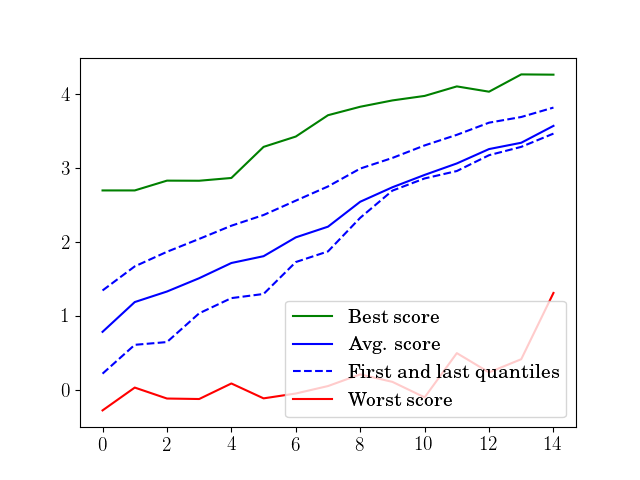

In [86]:
bestByGen = genLog[:,0,0]
avgByGen = np.average(genLog[:,0], axis=1)
worstByGen = genLog[:,0,-1]

# show first, median and last quantile
quantByGen = []
nbQuantiles = 4
for i in range(nbQuantiles):
    quantByGen.append(np.quantile(genLog[:,0], i/nbQuantiles, axis=1))

%matplotlib notebook
plt.plot(bestByGen, 'g', label='Best score')
plt.plot(avgByGen, 'b', label='Avg. score')
plt.plot(quantByGen[1], 'b--', label='First and last quantiles')
plt.plot(quantByGen[nbQuantiles-1], 'b--')
plt.plot(worstByGen, 'r', label='Worst score')
plt.legend()